In [1]:
import os
import glob
import datetime
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import curve_fit

#from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

import gsf_ims_fitness as fitness

import pickle

import random

import gzip

import seaborn as sns
sns.set()

#from sklearn.mixture import GaussianMixture
#from sklearn.mixture import BayesianGaussianMixture

%load_ext autoreload
%autoreload 2

%matplotlib inline

%autosave 0

sns.set_style("white")
sns.set_style("ticks", {'xtick.direction':'in', 'xtick.top':True, 'ytick.direction':'in', 'ytick.right':True})

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.edgecolor'] = 'k'

Autosave disabled


In [2]:
notebook_directory = os.getcwd()
notebook_directory

'C:\\Users\\djross\\Documents\\Edrive\\engineering-bio-lacI-landscape'

In [3]:
target_tsv_directory = notebook_directory + "\\data_0\\processed\\targets"
os.chdir(target_tsv_directory)
target_tsv_directory

'C:\\Users\\djross\\Documents\\Edrive\\engineering-bio-lacI-landscape\\data_0\\processed\\targets'

In [389]:
pacbio_files = glob.glob("*.tsv.gz")
pacbio_files

['barcode_1.tsv.gz',
 'barcode_2.tsv.gz',
 'empty_1.tsv.gz',
 'empty_2.tsv.gz',
 'insulator.tsv.gz',
 'KAN.tsv.gz',
 'lacI.tsv.gz',
 'Ori.tsv.gz',
 'tetA.tsv.gz',
 'YFP.tsv.gz']

In [390]:
regions = [ x[:x.find(".tsv.gz")] for x in pacbio_files ]
regions

['barcode_1',
 'barcode_2',
 'empty_1',
 'empty_2',
 'insulator',
 'KAN',
 'lacI',
 'Ori',
 'tetA',
 'YFP']

In [457]:
region = "YFP"
file = region + ".tsv.gz"
file

'YFP.tsv.gz'

In [458]:
wild_type_dict = {}
trim_dict = {}
wild_type_dict["empty_1"] = "CTAGCGCTGAGGTCTGCCTCGTGCAGCGAGTCAGTGAGCGAGGAAGCACCTCAGATAAAATATTTGCTCATGAGCCCGAAGTGGCGAGCCCGACAAAAAACCCCTCAAGACCCGTTTAGAGGCCCCAAGGGGTTATGCTAGTCTTCCCCATCGGTGAGCCCGGGCTGTCGGCGT"
trim_dict["empty_1"] = 25
wild_type_dict["empty_2"] = "CGGTGGCCCGGGCGGCCGCACGATGCGTCCGGCGTAGAGGATCTGCTCATGTTTGACAGCTTATCATCGATGCATAATGTGCCTGTCAAATGGACGAAGCAGGGATTCTGCAAACCCTATGCTACTCCCTCGAGCCGTCAATTGTCTGATTCGTTACCAATTATTTTTTCCTCCTGGATTA"
trim_dict["empty_2"] = 25
wild_type_dict["insulator"] = "ATTCACCACCCTGAATTGACTCTCTTCCGGGCGCTATCATGCCATACCGCGAAAGGTTTTGCGCCATTCGATGGCGCGCCGCCATAAATCTCGGTACCAAATTCCAGAAAAGAGGCCTCCCGAAAGGGGGGCCTTTTTTCGTTTTGGTCCGAGCTGTTGACAATTAATCATCGGCTCGTATAATGTGTGGAATTGTGAGCGGATAACAATTAGCTGTCACCGGATGTGCTTTCCGGTCTGATGAGTCCGTGAGGACGAAACAGCCTCTACAAATAATTTTGTTTAATACTAGCCATCAAGGAGAGCTGCTAC"
trim_dict["insulator"] = 25
wild_type_dict["KAN"] = "AAGCGGGAGACCAGAAACAAAAAAAGGCCCCCCGTTAGGGAGGCCTTCAATAATTGGTTGTGTCTCAAAATCTCTGATGTACATTGCACAAGATAAAAATATATCATCATGAACAATAAAACTGTCTGCTTACATAAACAGTAATACAAGGGGTGTTATGAGCCATATTCAACGGGAAACGTCTTGCTCCAGGCCGCGATTAAATTCCAACATGGATGCTGATTTATATGGGTATAAATGGGCTCGCGATAATGTCGGGCAATCAGGTGCGACAATCTATCGATTGTATGGGAAGCCCGATGCGCCAGAGTTGTTTCTGAAACATGGCAAAGGTAGCGTTGCCAATGATGTTACAGATGAGATGGTCAGACTAAACTGGCTGACGGAATTTATGCCTCTTCCGACCATCAAGCATTTTATCCGTACTCCTGATGATGCATGGTTACTCACCACTGCGATCCCCGGGAAAACAGCATTCCAGGTATTAGAAGAATATCCTGATTCAGGTGAAAATATTGTTGATGCGCTGGCAGTGTTCCTGCGCCGGTTGCATTCGATTCCTGTTTGTAATTGTCCTTTTAACAGCGATCGCGTATTTCGTCTCGCTCAGGCGCAATCACGAATGAATAACGGTTTGGTTGATGCGAGTGATTTTGATGACGAGCGTAATGGCTGGCCTGTTGAACAAGTCTGGAAAGAAATGCATAAGCTTTTGCCATTCTCACCGGATTCAGTCGTCACTCATGGTGATTTCTCACTTGATAACCTTATTTTTGACGAGGGGAAATTAATAGGTTGTATTGATGTTGGACGAGTCGGAATCGCAGACCGATACCAGGATCTTGCCATCCTATGGAACTGCCTCGGTGAGTTTTCTCCTTCATTACAGAAACGGCTTTTTCAAAAATATGGTATTGATAATCCTGATATGAATAAATTGCAGTTTCATTTGATGCTCGATGAGTTTTTCTAAGGTAACTGTCAGACCAAGTTTACTCATATATACTTTAGATTGATTTTTCGTTCCACTGAGCGTCAGACCCC"
trim_dict["KAN"] = 0
wild_type_dict["lacI"] = "TCACTGCCCGCTTTCCAGTCGGGAAACCTGTCGTGCCAGCTGCATTAATGAATCGGCCAACGCGCGGGGAGAGGCGGTTTGCGTATTGGGCGCCAGGGTGGTTTTTCTTTTCACCAGTGAGACTGGCAACAGCTGATTGCCCTTCACCGCCTGGCCCTGAGAGAGTTGCAGCAAGCGGTCCACGCTGGTTTGCCCCAGCAGGCGAAAATCCTGTTTGATGGTGGTTAACGGCGGGATATAACATGAGCTATCTTCGGTATCGTCGTATCCCACTACCGAGATATCCGCACCAACGCGCAGCCCGGACTCGGTAATGGCGCGCATTGCGCCCAGCGCCATCTGATCGTTGGCAACCAGCATCGCAGTGGGAACGATGCCCTCATTCAGCATTTGCATGGTTTGTTGAAAACCGGACATGGCACTCCAGTCGCCTTCCCGTTCCGCTATCGGCTGAATTTGATTGCGAGTGAGATATTTATGCCAGCCAGCCAGACGCAGACGCGCCGAGACAGAACTTAATGGGCCCGCTAACAGCGCGATTTGCTGGTGACCCAATGCGACCAGATGCTCCACGCCCAGTCGCGTACCGTCCTCATGGGAGAAAATAATACTGTTGATGGGTGTCTGGTCAGAGACATCAAGAAATAACGCCGGAACATTAGTGCAGGCAGCTTCCACAGCAATGGCATCCTGGTCATCCAGCGGATAGTTAATGATCAGCCCACTGACGCGTTGCGCGAGAAGATTGTGCACCGCCGCTTTACAGGCTTCGACGCCGCTTCGTTCTACCATCGACACCACCACGCTGGCACCCAGTTGATCGGCGCGAGATTTAATCGCCGCGACAATTTGCGACGGCGCGTGCAGGGCCAGACTGGAGGTGGCAACGCCAATCAGCAACGACTGTTTGCCCGCCAGTTGTTGTGCCACGCGGTTGGGAATGTAATTCAGCTCCGCCATCGCCGCTTCCACTTTTTCCCGCGTTTTCGCAGAAACGTGGCTGGCCTGGTTCACCACGCGGGAAACGGTCTGATAAGAGACACCGGCATACTCTGCGACATCGTATAACGTTACTGGTTTCAT"
trim_dict["lacI"] = 0
wild_type_dict["Ori"] = "TTAATAAGATGATCTTCTTGAGATCGTTTTGGTCTGCGCGTAATCTCTTGCTCTGAAAACGAAAAAACCGCCTTGCAGGGCGGTTTTTCGAAGGTTCTCTGAGCTACCAACTCTTTGAACCGAGGTAACTGGCTTGGAGGAGCGCAGTCACCAAAACTTGTCCTTTCAGTTTAGCCTTAACCGGCGCATGACTTCAAGACTAACTCCTCTAAATCAATTACCAGTGGCTGCTGCCAGTGGTGCTTTTGCATGTCTTTCCGGGTTGGACTCAAGACGATAGTTACCGGATAAGGCGCAGCGGTCGGACTGAACGGGGGGTTCGTGCATACAGTCCAGCTTGGAGCGAACTGCCTACCCGGAACTGAGTGTCAGGCGTGGAATGAGACAAACGCGGCCATAACAGCGGAATGACACCGGTAAACCGAAAGGCAGGAACAGGAGAGCGCACGAGGGAGCCGCCAGGGGGAAACGCCTGGTATCTTTATAGTCCTGTCGGGTTTCGCCACCACTGATTTGAGCGTCAGATTTCGTGATGCTTGTCAGGGGGGCGGAGCCTATGGAAAAACGGCTTTGCCGCGGCCCTCTCACTTCCCTGTTAAGTATCTTCCTGGCATCTTCCAGGAAATCTCCGCCCCGTTCGTAAGCCATTTCCGCTCGCCGCAGTCGAACGACCGAGCGTAGCGAGTCAGTGAGCGAGGAAGCGGAATATATCCTGTATCACATATTCTGCTGACGCACCGGTGCAGCCTTTTTTCTCCTGCCACATGAAGCACTTCACTGACACCCTCATCAGTGCCAACATAGT"
trim_dict["Ori"] = 0
wild_type_dict["tetA"] = "ATGAGTAGCAGTACGAAAATTGCGCTTGTCATCACCCTCCTGGATGCGATGGGGATCGGCTTGATCATGCCGGTACTGCCAACCCTTCTGCGCGAGTTCATTGCAAGCGAAGATATTGCCAACCATTTCGGGGTTCTGCTCGCACTGTACGCCTTAATGCAGGTCATCTTTGCTCCCTGGTTAGGCAAAATGTCAGACAGCTTTGGACGCCGTCCTGTTTTGCTGTTAAGCCTTATCGGAGCGAGCCTGGATTACCTTTTATTGGCCTTCTCCTCGGCACTGTGGATGCTTTATTTGGGTCGTTTGCTGAGTGGGATTACAGGCGCGACGGGTGCCGTGGCGGCGTCGGTGATTGCTGATACGACGTCCGCAAGTCAACGTGTGAAATTGTTCGGCTGGTTAGGAGCCTCCTTTGGCTTGGGCTTAATCGCTGGGCCAATTATTGGCGGGTTCGCCGGCGAAATCTCACCACATTCCCCTTTTTTCATCGCGGCATTACTCAACATTGTCACGTTCCTGGTGGTGATGTTCTGGTTCCGCGAAACGAAAAACACCCGCGATAACACGGATACAGAGGTGGGGGTTGAAACGCAATCGAACAGTGTGTACATCACGCTCTTCAAGACCATGCCCATCCTGCTCATCATCTACTTCTCCGCACAGTTGATTGGGCAAATCCCGGCCACAGTGTGGGTTTTGTTTACGGAAAACCGTTTCGGGTGGAACTCCATGATGGTGGGTTTCTCTCTGGCTGGATTGGGACTTCTGCATAGTGTTTTCCAGGCTTTCGTCGCTGGCCGTATTGCCACAAAGTGGGGAGAAAAAACCGCTGTATTGCTTGGTTTTATCGCAGATAGCTCTGCGTTTGCCTTCTTGGCATTTATTAGCGAAGGCTGGCTCGTGTTTCCGGTATTGATTCTGTTGGCTGGGGGCGGTATCGCATTACCCGCGCTGCAGGGAGTTATGTCTATTCAAACCAAATCACACCAACAAGGAGCGCTGCAAGGCTTACTTGTGTCCCTGACCAACGCAACCGGAGTCATCGGGCCACTTCTGTTCGCTGTAATTTATAACCACTCACTGCCAATTTGGGATGGATGGATCTGGATCATCGGTCTTGCCTTCTACTGCATCATCATTTTGCTGTCAATGACATTCATGCTGACGCCTCAAGCCCAAGGATCTAAACAAGAAACGAGTGCC"
trim_dict["tetA"] = 0
wild_type_dict["YFP"] = "TAACGGCGTAAGGAGGTATTTTTATGGTGTCAAAGGGTGAGGAACTGTTTACGGGGATCGTCCCGATTCTTGTTGAACTTGACGGCGACGTAAATGGTCACAAGTTTTCCGTATCGGGCGAAGGTGAGGGCGATGCGACTTATGGGAAATTAACACTGAAATTCATTTGCACCACCGGAAAACTGCCCGTTCCTTGGCCTACTCTGGTAACCACGTTCGGATATGGTTTACAGTGTTTTGCTCGCTACCCGGACCATATGAAACTGCACGATTTCTTCAAGTCCGCCATGCCGGAGGGCTACGTGCAGGAACGTACAATCTTCTTCAAAGACGATGGTAATTACAAGACCCGTGCTGAAGTTAAATTTGAGGGGGATACTTTAGTCAATCGTATTGAATTGAAGGGGATTGACTTTAAGGAAGACGGTAATATCCTTGGCCACAAGCTTGAATACAACTACAATAGTCACAATGTGTATATTATGGCTGATAAACAGAAGAATGGCATTAAGGTTAACTTTAAGATCCGTCACAATATCGAAGACGGATCTGTCCAGCTTGCTGACCATTATCAGCAAAATACGCCGATCGGTGACGGTCCGGTTTTGTTGCCGGACAACCATTACCTGTCCTATCAGTCGGCGTTAAGTAAAGATCCGAATGAGAAACGCGACCATATGGTTTTGTTGGAGTTTGTGACGGCTGCTGGCATTACGCTTGGGATGGACGAGCTGTATAAATAA"
trim_dict["YFP"] = 0

wild_type_seq = wild_type_dict[region]
adapt_len = trim_dict[region]

In [459]:
%%time

with gzip.open(file, 'rb') as f:
    region_frame = pd.read_csv(f, sep="\t", skipinitialspace=True)
    
if adapt_len>0:
    new_seqs = []
    for s in region_frame["seq"]:
        up = [ c.isupper() for c in s ]
        if True in up:
            n_s = s[up.index(True)-adapt_len:-up[::-1].index(True)+adapt_len][:350].upper()
            new_seqs.append(n_s)
        else:
            new_seqs.append("")
    region_frame["seq"] = new_seqs
    region_frame = region_frame[region_frame["seq"]!=""]
    region_frame = region_frame[region_frame["seq"].str.len()>2*adapt_len]
region_frame = region_frame[~region_frame["seq"].isnull()]

Wall time: 59.8 ms


In [460]:
len(region_frame)

7902

In [461]:
for s in region_frame["seq"].iloc[:5]:
    dist = fitness.levenshtein_distance(s[:25], wild_type_seq[:25])
    print(f"{s[:25]}, {s[:25]==wild_type_seq[:25]}, {dist}")
print()
print(wild_type_seq[:25])

TACGGCGTAAGGAGGTATTTTTATG, False, 2.0
TAACGGCGTAAGGAGGTATTTTTAT, True, 0.0
TAACGGCGTAAGGAGGTATTTTTAT, True, 0.0
TAACGGCGTAAGGAGGTATTTTTAT, True, 0.0
TAACGGCGTAAGGAGGTATTTTTAT, True, 0.0

TAACGGCGTAAGGAGGTATTTTTAT


In [462]:
for s in region_frame["seq"].iloc[:5]:
    dist = fitness.levenshtein_distance(s[-25:], wild_type_seq[-25:])
    print(f"{s[-25:]}, {s[-25:]==wild_type_seq[-25:]}, {dist}")
print()
print(wild_type_seq[-25:])

TGGGATGGACGAGCTGTATAAATAA, True, 0.0
TGGGATGGACGAGCTGTATAAATAA, True, 0.0
TGGGATGGACGAGCTGTATAAATAA, True, 0.0
TGGGATGGACGAGCTGTATAAATAA, True, 0.0
TGGGATGGACGAGCTGTATAAATAA, True, 0.0

TGGGATGGACGAGCTGTATAAATAA


In [463]:
print(str(Seq(wild_type_seq).reverse_complement())[:25])
print()
for s in region_frame["seq"].iloc[:5]:
    print(str(Seq(s).reverse_complement())[:25])
print()
print(wild_type_seq[:25])

TTATTTATACAGCTCGTCCATCCCA

TTATTTATACAGCTCGTCCATCCCA
TTATTTATACAGCTCGTCCATCCCA
TTATTTATACAGCTCGTCCATCCCA
TTATTTATACAGCTCGTCCATCCCA
TTATTTATACAGCTCGTCCATCCCA

TAACGGCGTAAGGAGGTATTTTTAT


In [464]:
region_frame["seq_length"] = [ len(x) for x in region_frame["seq"] ]

In [465]:
print(region_frame["seq_length"].max())

6389


In [466]:
print(region_frame["seq_length"].min())

20


In [467]:
seq_length_mode = region_frame["seq_length"].mode().values[0]
seq_length_mode

743

In [468]:
len(wild_type_seq)

743

5064

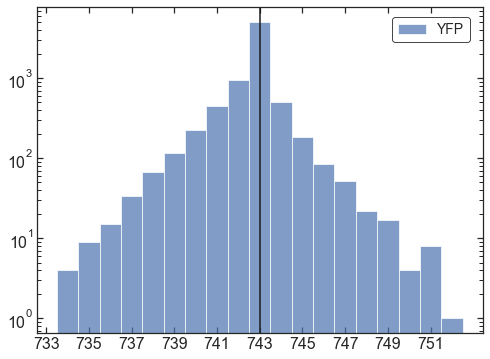

In [469]:
plt.rcParams["figure.figsize"] = [8, 6]
fig, axs = plt.subplots(1, 1)
bins= [i+0.5 for i in range(seq_length_mode-10, seq_length_mode+10)]

axs.hist(region_frame["seq_length"], bins=bins, alpha=0.7, label=region);
axs.set_yscale('log');
axs.set_xticks([i for i in range(seq_length_mode-10, seq_length_mode+10, 2)]);
ylim = axs.get_ylim()
xlim = axs.get_xlim()
axs.set_xlim(xlim)
for x, fmt in zip([-50, 0, 50], ["--", "-", "--"]):
    axs.plot([len(wild_type_seq)+x]*2, ylim, fmt+"k")
axs.set_ylim(ylim)
leg = axs.legend(loc='upper right', bbox_to_anchor= (0.97, 0.97), ncol=1, borderaxespad=0)
len(region_frame[region_frame["seq_length"]==seq_length_mode])